This is one of the two discriminators used on HiFiGAN

![CleanShot 2024-10-19 at 12.39.51@2x.png](<attachment:CleanShot 2024-10-19 at 12.39.51@2x.png>)
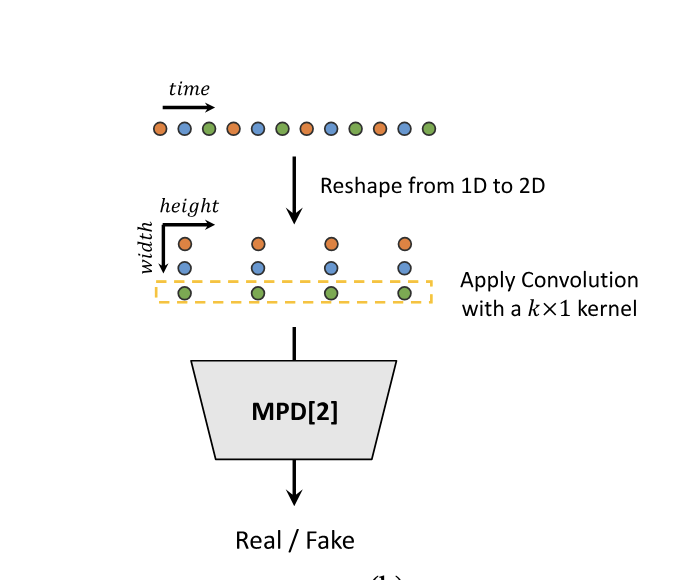

MPD is a sequence of small discriminators taking in audio at a certain input period ([2, 3, 5, 7, 11...]) to avoid overlap. It applies 2D convolutions on the data, the kernel size in the width is 1 so as to avoid period overlap. 

"Each
sub-discriminator is a stack of strided convolutional layers with leaky rectified linear unit (ReLU)
activation"

WeightNormalisation is applied to MPD as well.

In [2]:
import jax
import equinox as eqx
from equinox.nn import Conv2d

LRELU_SCOPE = 0.1

def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)

class DiscriminatorP(eqx.Module):
    layers: list
    period: int = eqx.static_field()
    conv_post: Conv2d

    def __init__(self, period, kernel_size=5, stride=3, key=None):

        self.period = period

        key1,key2,key3,key4,key5,key6 = jax.random.split(key, 6)

        self.layers = [
            Conv2d(1, 32, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0), key=key1),
            Conv2d(32, 128, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0), key=key2),
            Conv2d(128, 512, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0), key=key3),
            Conv2d(512, 1024, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0), key=key4),
            Conv2d(1024, 1024, (kernel_size, 1), 1, padding=(2, 0), key=key5),
        ]

        self.conv_post = Conv2d(1024, 1, (3, 1), 1, padding=(1, 0), key=key6)


    def pad_and_reshape(self, x):
        c, t = x.shape
        
        # Calculate padding amount
        n_pad = (self.period - (t % self.period)) % self.period  # Ensures no padding if already aligned
        
        # Apply padding
        x_padded = jax.numpy.pad(x, ((0, 0), (0, n_pad)), mode='reflect')
        
        # Reshape the array
        t_new = x_padded.shape[-1] // self.period
        return x_padded.reshape(c, t_new, self.period)

    def __call__(self, x):
        # Keep the feature map for the loss
        fmap = []

        y = self.pad_and_reshape(x)
        for layer in self.layers:
            y = eqx.nn.WeightNorm(layer)(y)
            y = jax.nn.leaky_relu(y, LRELU_SCOPE)
            fmap.append(y)
        y = eqx.nn.WeightNorm(self.conv_post)(y)
        fmap.append(y)

        y = jax.numpy.reshape(y, shape=(1, -1))
        return y, fmap
    

In [ ]:
# @jax.jit
# jax.config.update('jax_enable_x64', False)
def loss(model, x, y):
    result = jax.vmap(model)(x)
    return jax.numpy.mean(jax.numpy.abs(result - y)) # L1 loss

key1, key2, key3 = jax.random.split(jax.random.PRNGKey(69), 3)

x = jax.random.normal(key1, (10, 1, 100)).astype(jax.numpy.float32)
y = jax.random.normal(key2, (10, 1, 7)).astype(jax.numpy.float32)

model = DiscriminatorP(7, key=key3)

grads = loss(model, x, y)

In [39]:
class MultiPeriodDiscriminator(eqx.Module):
    discriminators: list

    def __init__(self, periods=[2, 3, 5, 7, 11], key=None):
        self.discriminators = []
        
        for period in periods:

            key, grab = jax.random.split(key, 2)
            self.discriminators.append(DiscriminatorP(period, key=grab))


    def __call__(self, gen, real):
        preds_gen = []
        preds_real = []
        fmaps_gen = []
        fmaps_real = []

        for disc in self.discriminators:
            pred, fmap = disc(gen)
            preds_gen.append(pred)
            fmaps_gen.append(fmap)

            pred, fmap = disc(real)
            preds_real.append(pred)
            fmaps_real.append(fmap)
        
        return preds_gen, preds_real, fmaps_gen, fmaps_real

In [ ]:
# @jax.jit
# jax.config.update('jax_enable_x64', False)
def loss(model, x, y):
    preds_gen, preds_real, fmaps_gen, fmaps_real = jax.vmap(model)(x, y)

    return jax.numpy.mean(jax.numpy.abs(fmaps_real - fmaps_gen)) # L1 loss

key1, key2, key3 = jax.random.split(jax.random.PRNGKey(69), 3)

x = jax.random.normal(key1, (10, 1, 100)).astype(jax.numpy.float32)
y = jax.random.normal(key2, (10, 1, 100)).astype(jax.numpy.float32)

model = MultiPeriodDiscriminator(key=key3)

grads = loss(model, x, y)

    The discriminator size is increased by reducing stride and adding
    more layers. Weight normalization is applied except for the first sub-discriminator, which operates on
    raw audio

There doesn't seem to be any information concerning where they pulled the convolutions beneath from...

In [27]:
from equinox.nn import Conv1d

class DiscriminatorS(eqx.Module):
    layers: list
    conv_post: Conv1d

    def __init__(self, key=None):
        key1,key2,key3,key4,key5,key6,key7,key8 = jax.random.split(key, 8)

        self.layers = [
                Conv1d(1, 128, 15, 2, padding=7, key=key1),
                Conv1d(128, 128, 41, 4, groups=4, padding=20, key=key2),
                Conv1d(128, 256, 41, 8, groups=16, padding=20, key=key3),
                Conv1d(256, 512, 41, 16, groups=16, padding=20, key=key4),
                Conv1d(512, 1024, 41, 16, groups=16, padding=20, key=key5),
                Conv1d(1024, 1024, 41, 4, groups=16, padding=20, key=key6),
                Conv1d(1024, 1024, 5, 1, padding=2, key=key7)
            ]
        self.conv_post = Conv1d(1024, 1, 3, 1, padding=1, key=key8)
        
    def __call__(self, x):
        # Feature map for loss
        y = x
        
        fmap = []
        for layer in self.layers: 
            y = layer(y)
            y = jax.nn.leaky_relu(y, LRELU_SCOPE)
            fmap.append(y)

        y = self.conv_post(y)
        fmap.append(y)
        y = jax.numpy.reshape(y, shape=(1, -1))

        return y, fmap
        

Curious that they don't have varying scales for the discriminators like we have with the ResBlocks varying kernel size, dilution, stride...

In [34]:
from equinox.nn import AvgPool1d

class MultiScaleDiscriminator(eqx.Module):
    discriminators: list
    avg_pools: AvgPool1d = eqx.static_field()
    # TODO need to add spectral norm things
    def __init__(self, key=None):
        key1,key2,key3 = jax.random.split(key, 3)

        self.discriminators = [
            DiscriminatorS(key1),
            DiscriminatorS(key2),
            DiscriminatorS(key3),
        ]
        self.avg_pools = AvgPool1d(4, 2, padding=2)

    def __call__(self, fake, real):
        preds_gen = []
        preds_real = []
        fmaps_gen = []
        fmaps_real = []

        for disc in self.discriminators:
            # print(fake.shape)
            # print(real.shape)
            



            pred, fmap = disc(fake)
            # print(pred.shape)
            preds_gen.append(pred)
            fmaps_gen.append(fmap)
            
            pred2, fmap2 = disc(real)
            # print(pred2.shape)
            preds_real.append(pred2)
            fmaps_real.append(fmap2)

            fake = self.avg_pools(fake)
            real = self.avg_pools(real)

        # print(preds_gen)
        # print(preds_real)
        
        return preds_gen, preds_real, fmaps_gen, fmaps_real



In [37]:
# @jax.jit
# jax.config.update('jax_enable_x64', False)
import optax

def loss(model, x, y):
    preds_gen, preds_real, _, _ = jax.vmap(model)(x, y)

    return jax.numpy.mean(jax.numpy.abs(jax.numpy.array(preds_gen) - jax.numpy.array(preds_real))) # L1 loss

loss = eqx.filter_grad(loss)

key1, key2, key3 = jax.random.split(jax.random.PRNGKey(69), 3)

x = jax.random.normal(key1, (10, 1, 64)).astype(jax.numpy.float32)
y = jax.random.normal(key2, (10, 1, 64)).astype(jax.numpy.float32)

model = MultiScaleDiscriminator(key=key3)

grads = loss(model, x, y)

optim2 = optax.adam(1e-5)
# Separate trainable and non-trainable parameters
trainable_params, static_params = eqx.partition(model, eqx.is_inexact_array)

# Initialize the optimizer on trainable parameters only
scale_optim = optim2.init(trainable_params)



(1, 64)
(1, 64)
(1, 1)
(1, 1)
(1, 33)
(1, 33)
(1, 1)
(1, 1)
(1, 17)
(1, 17)
(1, 1)
(1, 1)
[Traced<ShapedArray(float32[1,1])>with<BatchTrace(level=3/0)> with
  val = Traced<ConcreteArray([[[0.01797717]]

 [[0.01798195]]

 [[0.01797555]]

 [[0.01797751]]

 [[0.01797967]]

 [[0.0179795 ]]

 [[0.01798427]]

 [[0.01797718]]

 [[0.0179877 ]]

 [[0.01798239]]], dtype=float32)>with<JVPTrace(level=2/0)> with
    primal = Array([[[0.01797717]],

       [[0.01798195]],

       [[0.01797555]],

       [[0.01797751]],

       [[0.01797967]],

       [[0.0179795 ]],

       [[0.01798427]],

       [[0.01797718]],

       [[0.0179877 ]],

       [[0.01798239]]], dtype=float32)
    tangent = Traced<ShapedArray(float32[10,1,1])>with<JaxprTrace(level=1/0)> with
      pval = (ShapedArray(float32[10,1,1]), None)
      recipe = JaxprEqnRecipe(eqn_id=<object object at 0x77cb9025bb70>, in_tracers=(Traced<ShapedArray(float32[10,1,1]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[1,1]):JaxprTrace(level=1/

In [ ]:
def feature_loss(fmap_gen, fmap_real):
    loss = 0
    for dr, dg in zip(fmap_gen, fmap_real):
        for rl, gl in zip(dr, dg):
            loss += jax.numpy.mean(jax.numpy.abs(rl - gl))

    return loss*2

def discriminator_loss(preds_gen, preds_real):
    loss = 0
    r_losses = []
    g_losses = []
    for dr, dg in zip(preds_real, preds_gen):
        r_loss = jax.numpy.mean((1-dr)**2)
        g_loss = jax.numpy.mean(dg**2)
        loss += (r_loss + g_loss)
        r_losses.append(r_loss.item())
        g_losses.append(g_loss.item())

    return loss, r_losses, g_losses


def generator_loss(disc_outputs):
    loss = 0
    gen_losses = []
    for dg in disc_outputs:
        l = jax.numpy.mean((1-dg)**2)
        gen_losses.append(l)
        loss += l

    return loss, gen_losses